# Tutorial for KN injection and recovery with $\tt{bajes}$

This tutorial will show how to inject KN lightcurves for a BNS event and how to proceed with the inference of the parameters.

## Injection

First of all we have to generate some injected data using one of the model inside $\tt{bajes}$. 

For this example we choose $\tt{GrossmanKBP-1-isotropic}$, these input values:

- mej_isotropic: 0.03
- vel_isotropic: 0.13
- opac_isotropic: 8
- distance: 40
- eps_alpha: 1.3
- eps_time: 1
- eps_sigma: 0.11
- eps0: 1e18
- iota: 0.524
- time_shift: 0
- t_gps: 1187008857

and this set of bands:  [ B, g , R , I , z , K ].

In [ ]:
import numpy as np
from bajes.obs.kn import Lightcurve, __photometric_bands__

# compute time array 
t_axis   = np.logspace(np.log10(3600), np.log10(1296000), num=60)

# select bands
bands   = ['B', 'g', 'R', 'I', 'z', 'K']
lambdas = {bi: __photometric_bands__[bi] for bi in bands}

# inizialize Lightcurve object
light   = Lightcurve(times=t_axis, lambdas=lambdas, approx='GrossmanKBP-1-isotropic')

# set input values
params = {'mej_isotropic'      : 0.03,
          'vel_isotropic'      : 0.13,
          'opac_isotropic'     : 8,
          'distance'           : 40.,
          'eps_alpha'          : 1.3,
          'eps_time'           : 1,
          'eps_sigma'          : 0.11,
          'eps0'               : 1e18,
          'iota'               : 0.524,   
          'time_shift'         : 0.,  
          't_gps'              : 1187008857}

# compute injected lightcurves
injected_lightcurves = light.compute_mag(params)

The function $\tt{compute\_mag}$ returns a dictionary with keys the selected bands and items the array of generated magnitudes.

To prepare the right format of data for $\tt{bajes}$ inference, we have to:
- randomly generate the array of standard deviations, simply choosing an upper and lower value of sd (e.g. sigma_min=0.0001, sigma_max=0.)
- save the data: for every band, create a "band_name".txt file with three columns, $\qquad \tt{time} \qquad$	$\tt{magnitude}\qquad$	$\tt{std-mag}$.

Here the plot of the injected lightcurves:

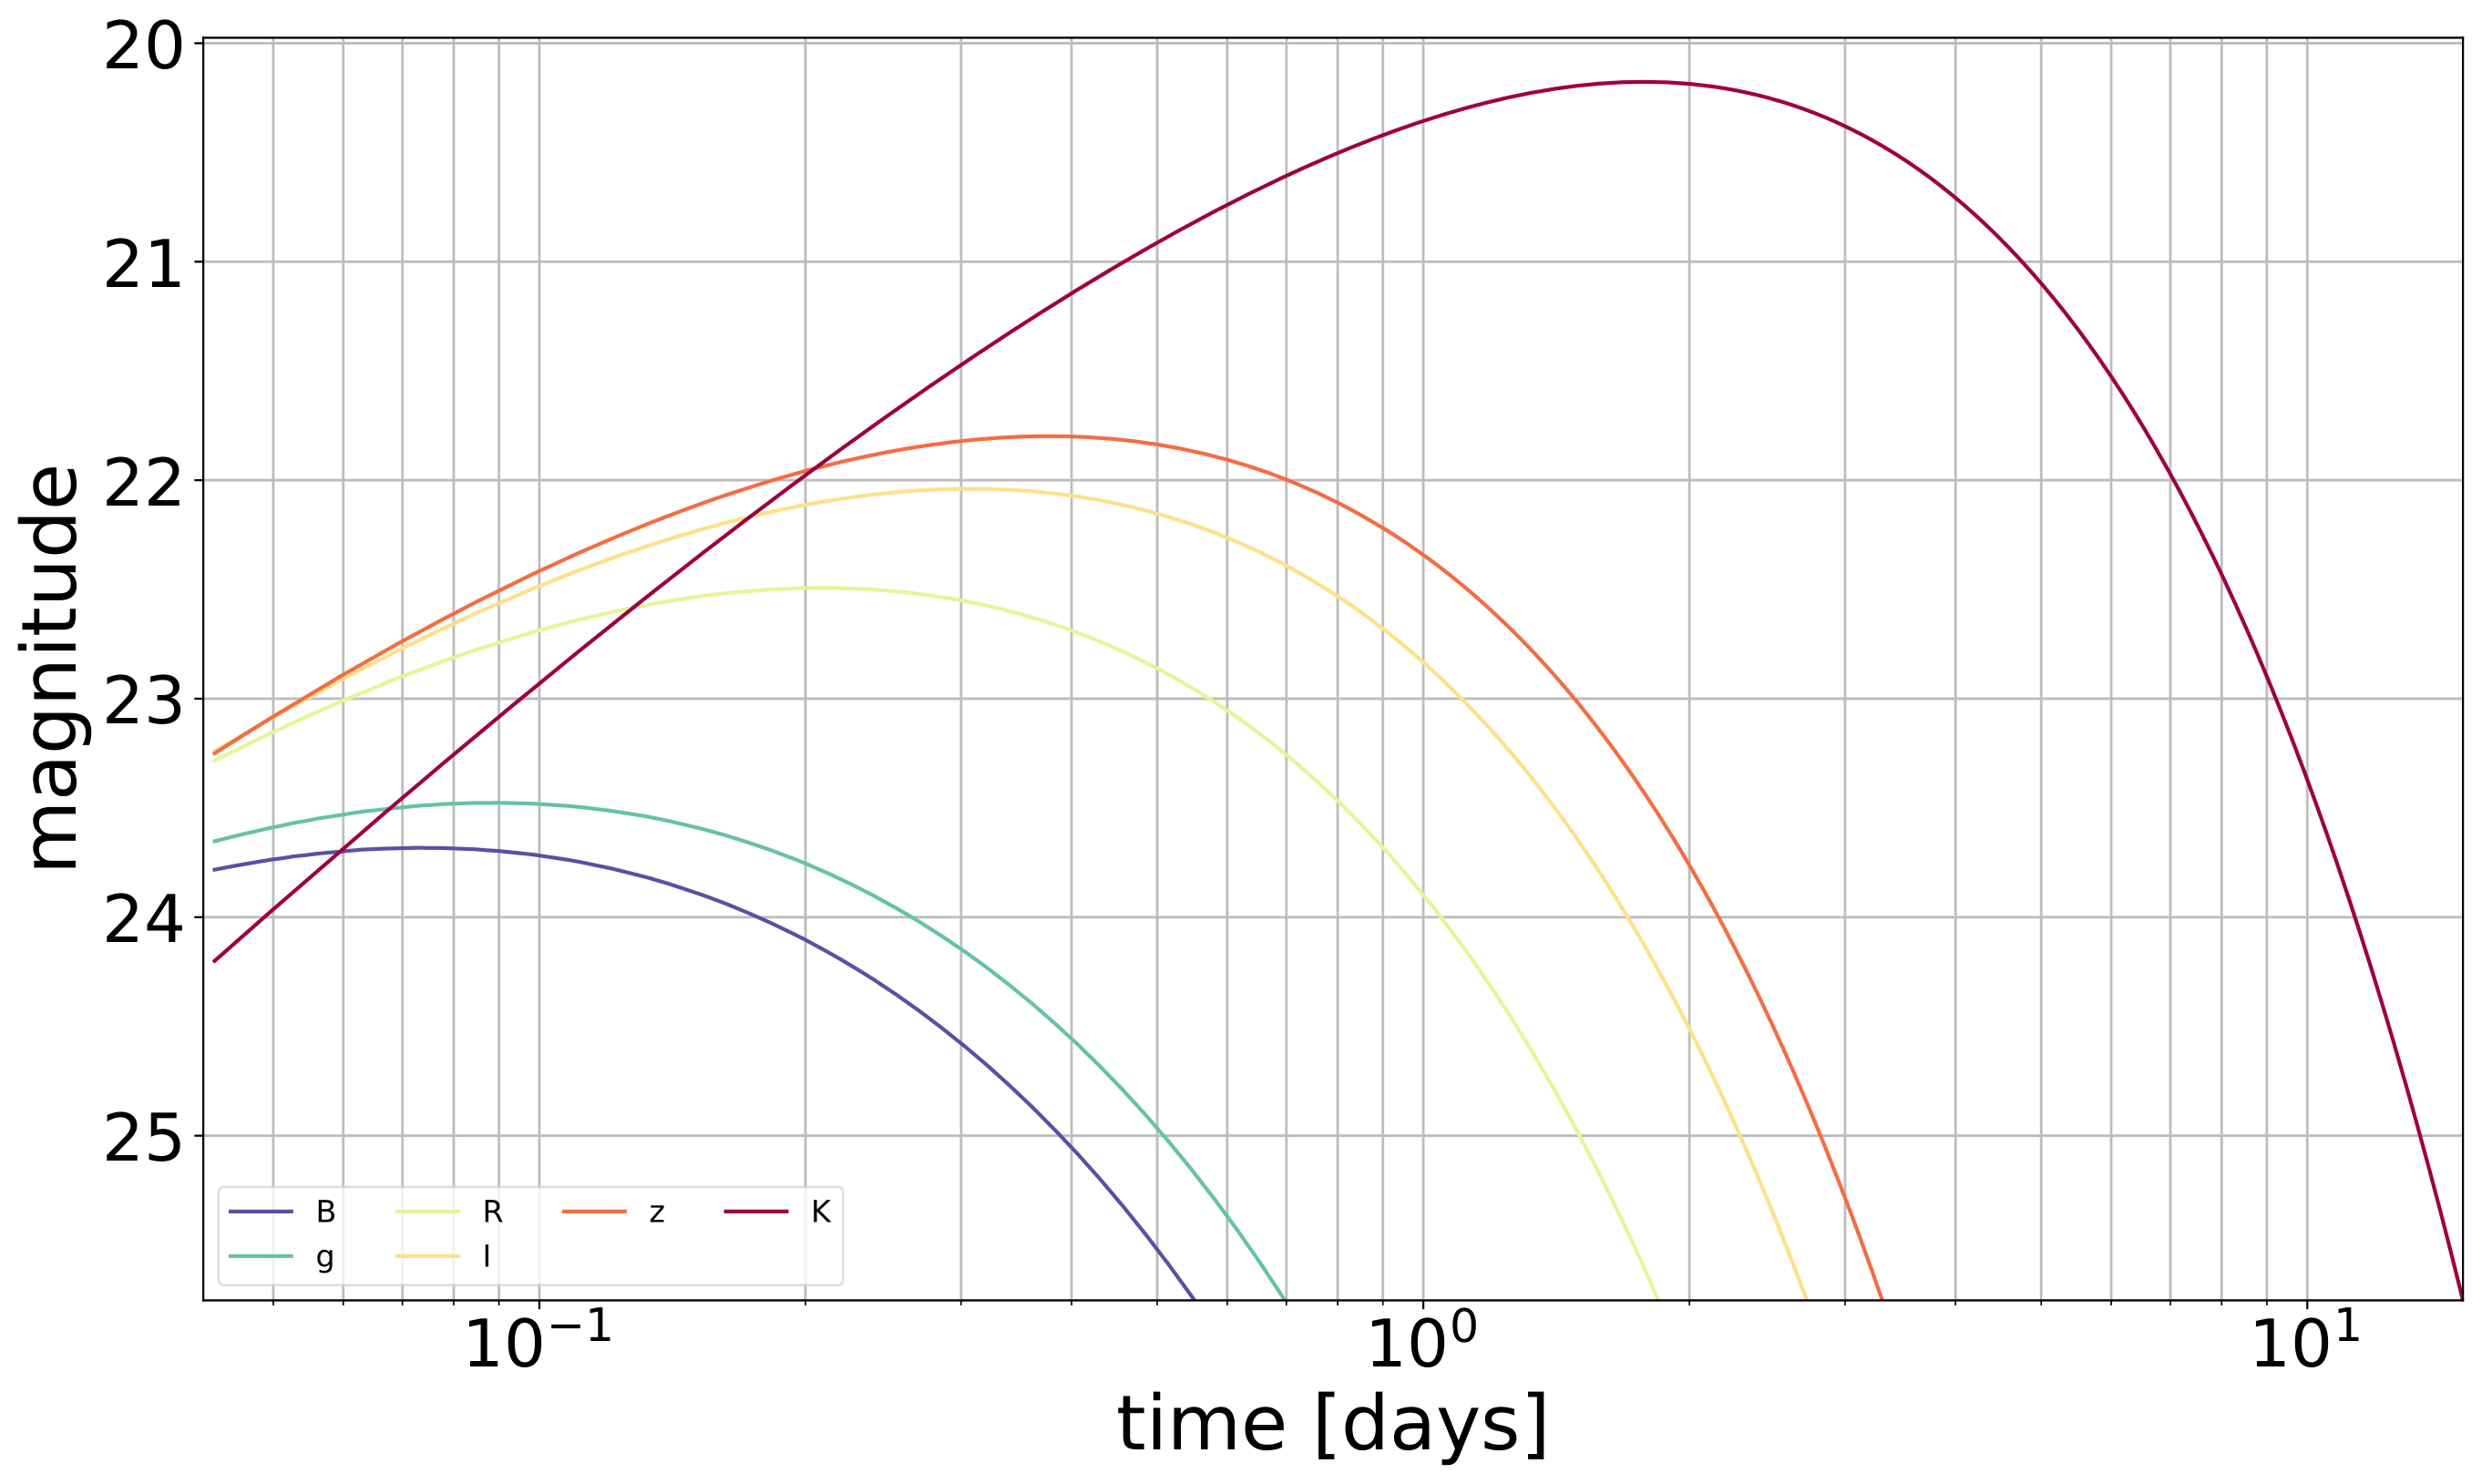

In [1]:
from IPython.display import Image
Image(filename="./plot-1.png")

## Inference

The inference can be started with two commands.

Setup command:

`bajes_setup --outdir ./run --tag kn --t-gps 1187008857 --kn-approx GrossmanKBP-1-isotropic --use-mag-dev --mag-folder ./Injected_data --band B --band g --band I --band R --band K --band z --use-dereddening --mej-max 1e-1 --mej-min 0 --vel-max 0.333 --vel-min 1e-3 --opac-max 30 --opac-min 0.1 --fix-name eps0 --fix-value 1e18 --tshift-max 25 --tshift-min 24 --dist-max 75. --dist-min 10.`

Inference command:

`python -m bajes -o ./run -I ./run/inf.pkl --checkpoint 1000 --engine dynesty --nlive 5000 --maxmcmc 15000 --tol 0.1 --seed 1234567`

In [ ]:
from bajes.pipe import execute_bash

setup_command = "bajes_setup -o ./run --tag gw --ifo H1 --asd design --strain ./injection/H1_INJECTION.txt --ifo L1 --asd design --strain ./injection/L1_INJECTION.txt --seglen 16 --srate 4096 --t-gps 126259462.0 --f-min 20 --f-max 2048 --gw-approx LALSimFD-IMRPhenomXP --mc-min 23 --mc-max 37 --q-max 8 --spin-flag align-isotropic --spin-max 0.9 --dist-min 100. --dist-max 5000. --marg-phi-ref --fd-inj"
execute_bash(setup_command)

inf_command = "python -m bajes -o ./run -I ./run/inf.pkl --checkpoint 1000 --engine dynesty --nlive 1024 --seed 1234567 --verbose"
execute_bash(inf_command)

## Postprocess

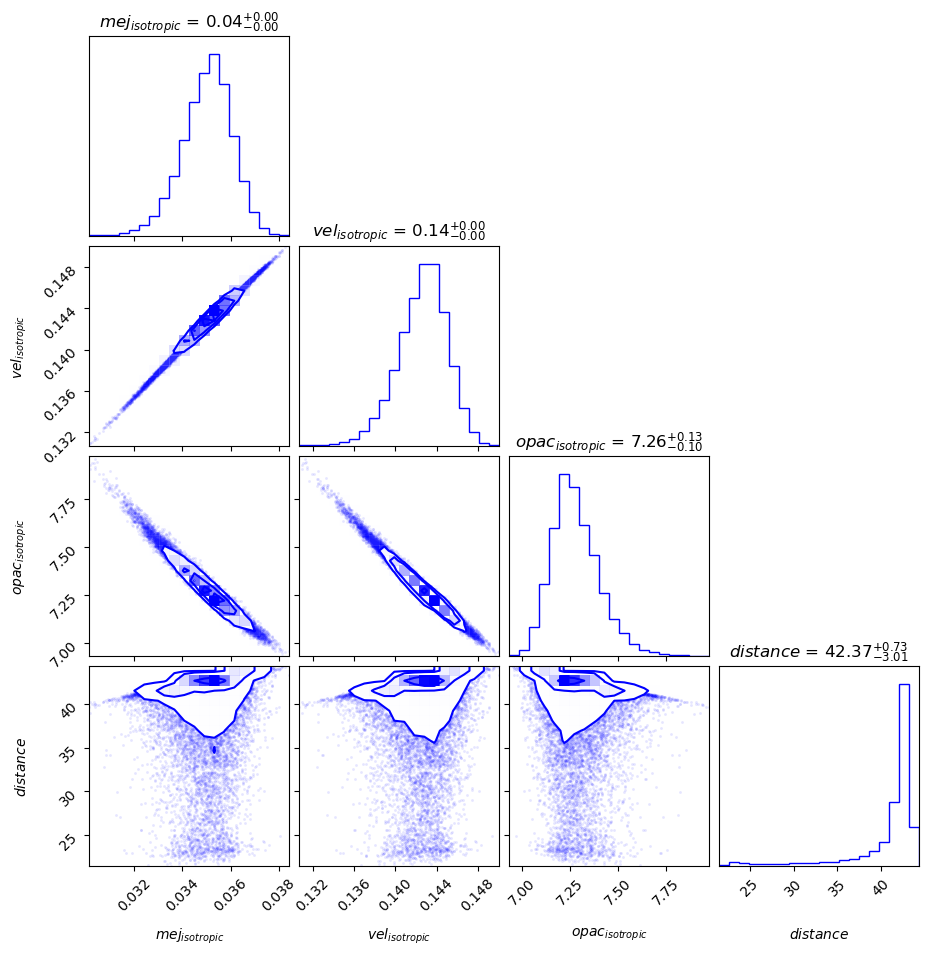

In [4]:
import corner
import numpy as np
import matplotlib.pyplot as plt

posterior_file = './posterior.dat'  			
posterior      = np.genfromtxt(posterior_file, names=True)

fig = corner.corner(np.vstack([posterior['mej_isotropic'], posterior['vel_isotropic'], posterior['opac_isotropic'], posterior['distance']]).T, 
                  labels=[r"$mej_{isotropic}$", r"$vel_{isotropic}$", r"$opac_{isotropic}$", r"$distance$"], show_titles=True, title_kwargs={"fontsize": 12}, color='blue')